# Question answering with TensorFlow

질문-답변(QA) 시스템은 자연언어형태로 이뤄진 질문에 답할 수 있도록 설계된 시스템을 말합니다. 몇몇 QA 시스템은 특정 질문에 답변하기 위해서 문구나 이미지 같은 원천으로부터 정보를 가져옵니다. 이런 “원천기반의” 시스템은 크게 두 개의 세부 카테고리로 나눠볼 수 있습니다. 하나는 개방형으로, 질문의 형태가 어떤 것이든 상관없지만, 그렇다고 특정 주제에 초점을 맞추고 있지 않은 형태가 있고, 또 다른 형태는 폐쇄형으로, 질문 형태가 세세한 제한을 가지고 있는데 그 제한이 사실 이미 정의된 원천과 관련 있는 형태입니다. (예를 들어 의약과 같이 특정 분야나 사전에 제공된 문구 같이 말입니다.)

 
이번 글에서는 TensorFlow를 활용해서 질문-답변 시스템을 만들고 코딩하는 과정을 여러분에게 소개할 것입니다. 우리는 신경망 기반의 폐쇄형 원천을 가진 QA 시스템을 만들 것입니다. 이 일을 하기 위해서는, Kumar가 그들의 논문인 “Ask Me Anything: Dynamic Memory Networks for Natural Language Processing.” 에서 소개한 Dynamic Memory Network(DMN)이라고 알려진 모델의 간소화된 형태를 사용할 것입니다.

 

시작하기에 앞서

 

Python 3기반의 TensorFlow 1.2버전을 설치하는 것에 덧붙여서 다음의 것들이 설치되었는지 확인하시기 바랍니다.

 

* Jupyter
* Numpy
* Matplotlib
 

부가적으로 학습과정을 보고 학습 속도 계수를 뽑기 위한 도구로 TQDM을 설치할 수 있겠지만 필수적이지는 않습니다. 이번 글을 위한 코드와 Jupyter Notebook은 GitHub에 올라가 있고, 한번 여러분들도 받아서 따라해 볼 것을 권합니다. 만약 TensorFlow를 처음 다뤄본다면, Aaron Schumacher가 TensorFlow가 무엇이고, 동작원리에 대해서 쓴 “Hello, TensorFlow”을 볼 것을 추천합니다. 만약 자연언어처리에 TensorFlow를 처음 써본다면, “Textual Entailment with TensorFlow”를 확인해볼 것을 권하는데, 이 글은 이 신경망을 만드는데 도움이 될 몇 가지 개념에 대해서 소개하고 있습니다.

 

이제 이와 관련된 라이브러리를 추가하는 것부터 시작해봅시다.# Question answering with TensorFlow


In [5]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL

vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 26397 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google

In [0]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile
import tarfile
import json 
import hashlib
import re
import itertools

### GloVe를 Parsing하고 미지의 토큰 다루기
 

“TensorFlow를 활용한 텍스트 동조” 편에서, 저는 sentence2sequence라는 API를 소개했었는데, 이 API는 문자열을 GloVe에 의해서 정의된 규칙에 기반한 행렬로 바꿔주는 함수입니다. 이 함수는 문자열을 각각의 토큰으로 분리해주는데, 이 때 토큰이란 간단히 말해 구두점이나 단어, 또는 단어들과 동등한 형태의 작은 문자열을 말합니다. 예를 들어 “Bill traveled to the kitchen,”이라는 문장에는 6개의 토큰들이 있습니다. 그 중 다섯 개는 각 단어로 구성되어 있고, 마지막이 마침표입니다. 각 토큰들은 개별적으로 벡터화되어 있고, 결과적으로 그림 2에서 보여지는 것과 같이 각 문장으로 구성된 벡터의 집합으로 나타납니다.

bAbI의 몇몇 작업들 내에서, 시스템은 GloVe 단어 벡터화에 들어있지 않은 단어들과 만날 수 있습니다. 이렇게 신경망 내에서 미지의 단어들을 처리하기 위해서 우리는 그런 단어들에 대해서도 일관된 벡터화 과정을 유지해야 합니다. 가장 흔한 방법은 모든 미지의 토큰들을 <UNK>벡터로 바꾸는 것인데, 이 방법은 항상 효율적이지 않습니다. 대신에 우리는 각 미지의 토큰들에 대해서 새 벡터를 그리기 위해서, 우리는 랜덤 기법을 사용합니다. 

 

새로운 미지의 토큰을 접했을 때 우선 기존의 (Gaussian 근사) 분포를 따르는 기존의 GloVe 벡터로부터 새로운 벡터를 만들고, 그걸 다시 GloVe 단어맵에 추가합니다. 분포에 대한 Hyperparameter를 얻기 위해서, Numpy library는 자동으로 분산과 평균을 계산해주는 함수를 가지고 있습니다.

 

fill_unk 는 우리가 언제든 새로운 단어에 대한 벡터를 얻을 수 있게끔 해줍니다.

In [0]:
root_name = 'drive/Project/snu_fira_2018/'

glove_vectors_file = root_name + "glove.6B/glove.6B.50d.txt"


#Select "task 5"
train_set_file = "qa5_three-arg-relations_train.txt"
test_set_file = "qa5_three-arg-relations_test.txt"

train_set_post_file = root_name + "tasks_1-20_v1-2/en/"+train_set_file
test_set_post_file = root_name + "tasks_1-20_v1-2/en/"+test_set_file

In [0]:
# Deserialize GloVe vectors
glove_wordmap = {}
with open(glove_vectors_file, "r", encoding="utf8") as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

In [0]:
wvecs = []
for item in glove_wordmap.items():
    wvecs.append(item[1])
s = np.vstack(wvecs)

# Gather the distribution hyperparameters
v = np.var(s,0) 
m = np.mean(s,0) 
RS = np.random.RandomState()

def fill_unk(unk):
    global glove_wordmap
    glove_wordmap[unk] = RS.multivariate_normal(m,np.diag(v))
    return glove_wordmap[unk]

### 알려진 것과 알려지지 않은 것

 

bAbI 작업에 쓰이는 제한된 어휘는 신경망이 굳이 단어가 무슨 뜻을 가지는 알 필요 없이 단어들 사이의 관계를 배울 수 있다는 것을 의미합니다. 하지만 학습 속도를 위해서라도 고유의 의미를 가지는 벡터화 작업을 선택해야 합니다. 이를 위해서 Stanford 대학에서 배포한 GloVe 단어 벡터 데이터 집합 내에 존재하는 단어들에 대한 greedy 탐색을 사용하고, 만약 단어가 존재하지 않을 경우, 우리는 미지의, 랜덤하게 생성되고, 새로운 의미를 나타내는 전체 단어를 채워 넣어야 합니다.

 

단어 벡터 모델을 통해 우리는 새로운 sentence2sequence를 정의할 수 있습니다.

In [0]:
def sentence2sequence(sentence):
    """
     
    - Turns an input paragraph into an (m,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.
    
      TensorFlow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      TensorFlow provides. Normal Python suffices for this task.
    """
    tokens = sentence.strip('"(),-').lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
                continue
            else:
                i = i-1
            if i == 0:
                # word OOV
                # https://arxiv.org/pdf/1611.01436.pdf
                rows.append(fill_unk(token))
                words.append(token)
                break
    return np.array(rows), words

이제 문맥, 질문, 답변의 벡터들을 포함한, 각 질문에 필요한 데이터들을 하나로 묶을 수 있습니다. bAbI에서 문맥은 몇몇 문장의 연속된 형태로 정의되는데, 이 것들은 contextualize이 여러 개의 문장을 하나의 문맥으로 비직렬화하면서 만들어진 것입니다. 질문과 답변들은 같은 줄 상에 있고, 탭으로 나눠져 있기 때문에 우리는 탭을 이용해서 특정 줄이 질문인지 아닌지를 가리는 용도로 사용할 수 있습니다. 번호 매기기가 재설정되면, 향후에 나올 질문들은 새로운 문맥을 참조하게 됩니다. (참고로 단일 문맥에 상응하는 질문이 하나 이상이 되는 경우가 가끔 있습니다.) 답변은 우리가 가지고 있지만 사용할 필요가 없는 정보도 가지고 있는데, 질문에 대답하는데 필요한 문장에 대한 숫자 같은 게 그런 것입니다. 우리 시스템 상에서는 신경망이 어떤 문장이 질문에 대답하는데 필요한 것인지를 스스로 가르칠 것입니다.

In [0]:
def contextualize(set_file):
    """
    Read in the dataset of questions and build question+answer -> context sets.
    Output is a list of data points, each of which is a 7-element tuple containing:
        The sentences in the context in vectorized form.
        The sentences in the context as a list of string tokens.
        The question in vectorized form.
        The question as a list of string tokens.
        The answer in vectorized form.
        The answer as a list of string tokens.
        A list of numbers for supporting statements, which is currently unused.
    """
    data = []
    context = []
    with open(set_file, "r", encoding="utf8") as train:
        for line in train:
            l, ine = tuple(line.split(" ", 1))
            # Split the line numbers from the sentences they refer to.
            if l is "1":
                # New contexts always start with 1, 
                # so this is a signal to reset the context.
                context = []
            if "\t" in ine: 
                # Tabs are the separator between questions and answers,
                # and are not present in context statements.
                question, answer, support = tuple(ine.split("\t"))
                data.append((tuple(zip(*context))+
                             sentence2sequence(question)+
                             sentence2sequence(answer)+
                             ([int(s) for s in support.split()],)))
                # Multiple questions may refer to the same context, so we don't reset it.
            else:
                # Context sentence.
                context.append(sentence2sequence(ine[:-1]))
    return data
train_data = contextualize(train_set_post_file)
test_data = contextualize(test_set_post_file)

In [0]:
final_train_data = []
def finalize(data):
    """
    Prepares data generated by contextualize() for use in the network.
    """
    final_data = []
    for cqas in data:
        contextvs, contextws, qvs, qws, avs, aws, spt = cqas

        lengths = itertools.accumulate(len(cvec) for cvec in contextvs)
        context_vec = np.concatenate(contextvs)
        context_words = sum(contextws,[])
        
        # Location markers for the beginnings of new sentences.
        sentence_ends = np.array(list(lengths)) 
        final_data.append((context_vec, sentence_ends, qvs, spt, context_words, cqas, avs, aws))
    return np.array(final_data)
final_train_data = finalize(train_data)   
final_test_data = finalize(test_data)     

### Hyperparameter 정의

 

여기서 우리는 우리가 학습시킬 데이터와 검증을 위한 데이터를 모두 준비했습니다. 다음 작업은 우리가 사용할 신경망이 데이터를 이해할 수 있도록 만드는 작업입니다. TensorFlow 기본 그래프를 치움으로써 우리가 무언가를 변화시켰을 때 신경망을 다시 돌릴 수 있는 옵션을 가지고 있다는 사실부터 시작해봅시다.

In [0]:
tf.reset_default_graph()

사실 이게 진짜 신경망의 서두이기 때문에, 신경망에 필요한 모든 상수들도 정의해봅시다. 우리는 이걸 hyperparameter라고 부르는데, 이 값들은 신경망의 외관과 학습에 대해서 정의합니다.

In [0]:
# Hyperparameters

# The number of dimensions used to store data passed between recurrent layers in the network.
recurrent_cell_size = 128

# The number of dimensions in our word vectorizations.
D = 50 

# How quickly the network learns. Too high, and we may run into numeric instability 
# or other issues.
learning_rate = 0.005

# Dropout probabilities. For a description of dropout and what these probabilities are, 
# see Entailment with TensorFlow.
input_p, output_p = 0.5, 0.5

# How many questions we train on at a time.
batch_size = 128

# Number of passes in episodic memory. We'll get to this later.
passes = 4

# Feed Forward layer sizes: the number of dimensions used to store data passed from feed-forward layers.
ff_hidden_size = 256

weight_decay = 0.00000001
# The strength of our regularization. Increase to encourage sparsity in episodic memory, 
# but makes training slower. Don't make this larger than leraning_rate.

training_iterations_count = 400000
# How many questions the network trains on each time it is trained. 
# Some questions are counted multiple times.

display_step = 100
# How many iterations of training occur before each validation check.

### 신경망 구조

 

Hyperparameter에 대해서 끝났으니 이제 신경망 구조에 대해 묘사해보겠습니다.  이 신경망의 구조는 대충 4개의 모듈로 나눠지고 Ask Me Anything: Dynamic Memory Networks for Natural Language Processing 에 묘사되어 있습니다.

 

신경망은 순환(recurrent) 계층의 메모리가 동적으로 설정되게끔 설계되어 있고, 이건 텍스트속의 다른 정보를 기반으로 만들어진건데, 보통 이걸 Dynamic Memory Network(DMN)이라고 합니다. DMN은 보통 인간이 읽고-이해하는 종류의 질문에 대해서 답변할 때 시도하는 방법에 대한 이해에 기반한 것입니다. 우선 사람은 문맥을 읽고, 그 속에서 사실에 대한 기억을 생산할 기회를 잡습니다. 그런 사실들이 마음속에 있고 난 후에 사람들은 질문을 읽고, 그 질문을 각 사실과 비교해보면서 질문에 대한 답변을 세밀하게 찾기 위해 문맥을 재탐색합니다. 

 때때로 한가지 사실이 다른 것을 유도하기도 합니다. bAbI 데이터 집합군에서 신경망은 축구의 위치를 찾기를 원할 것입니다. John이 축구공을 만진 마지막 사람이었다는 사실을 찾기 위해 축구에 대한 문장을 검색한 다음, John이 침실과 복도에 모두 있었음을 알기 위해 John에 대한 문장을 검색할 수 있습니다.
 
 #### Input

 

Input 모듈은 4개의 모듈중 가장 첫번째로, Dynamic Memory Network이 입력에 대한 대답을 내놓기 위한 모듈이고, 증거들을 얻기 위해서 입력에 대한 통로가 GRU라고 불리는 Gated Recurrent Unit과 함께 있는 형태로 구성되어 있습니다. (TensorFlow에서는 tf.contrib.nn.GRUCell에 있습니다.) 사실이라고 언급되는 각각의 증거들은 문맥 속에서 하나의 문장의 형태로 나타나고, 각 시간대별로 출력으로 표현됩니다. 이런 과정은 약간의 TensorFlow 이외의 전처리 과정이 필요하기 때문에 문장의 끝 부분을 모아서 나중에 모듈로 사용하기 위해서 TensorFlow로 전달할 수 있습니다.

 

우리는 학습 과정을 거칠 때 외적으로 필요한 처리 과정에 대해서 다룰 예정입니다. 그리고 관련된 출력을 선택하기 위해서 TensorFlow에서 제공하는 gather_nd 라는 함수를 통해 처리된 데이터를 활용할 수 있습니다. gather_nd 함수는 엄청나게 유용한 함수이며, 한번 API 문서를 통해서 이게 어떻게 동작하는지 확인해보실 것을 추천해드립니다.

In [0]:
# Input Module

# Context: A [batch_size, maximum_context_length, word_vectorization_dimensions] tensor 
# that contains all the context information.
context = tf.placeholder(tf.float32, [None, None, D], "context")  
context_placeholder = context # I use context as a variable name later on

# input_sentence_endings: A [batch_size, maximum_sentence_count, 2] tensor that 
# contains the locations of the ends of sentences. 
input_sentence_endings = tf.placeholder(tf.int32, [None, None, 2], "sentence")

# recurrent_cell_size: the number of hidden units in recurrent layers.
input_gru = tf.contrib.rnn.GRUCell(recurrent_cell_size)

# input_p: The probability of maintaining a specific hidden input unit.
# Likewise, output_p is the probability of maintaining a specific hidden output unit.
gru_drop = tf.contrib.rnn.DropoutWrapper(input_gru, input_p, output_p)

# dynamic_rnn also returns the final internal state. We don't need that, and can
# ignore the corresponding output (_). 
input_module_outputs, _ = tf.nn.dynamic_rnn(gru_drop, context, dtype=tf.float32, scope = "input_module")

# cs: the facts gathered from the context.
cs = tf.gather_nd(input_module_outputs, input_sentence_endings)
# to use every word as a fact, useful for tasks with one-sentence contexts
s = input_module_outputs 

#### Question

 

Question 모듈은 두번째 모듈인데, 이론적으로 말하면 가장 간단합니다. 이번에는 질문의 텍스트에 대해서 또다른 GRU 경로로 구성됩니다. 앞에서 다뤘던 증거 대신에 우리는 한 문장으로 길게 설정된 자료에 의해 보장된 질문을 통해서 단순히 최종 상태를 전달할 수 있습니다.

 

In [0]:
# Question Module

# query: A [batch_size, maximum_question_length, word_vectorization_dimensions] tensor 
#  that contains all of the questions.

query = tf.placeholder(tf.float32, [None, None, D], "query")

# input_query_lengths: A [batch_size, 2] tensor that contains question length information. 
# input_query_lengths[:,1] has the actual lengths; input_query_lengths[:,0] is a simple range() 
# so that it plays nice with gather_nd.
input_query_lengths = tf.placeholder(tf.int32, [None, 2], "query_lengths")

question_module_outputs, _ = tf.nn.dynamic_rnn(gru_drop, query, dtype=tf.float32, 
                                               scope = tf.VariableScope(True, "input_module"))

# q: the question states. A [batch_size, recurrent_cell_size] tensor.
q = tf.gather_nd(question_module_outputs, input_query_lengths)

#### Episodic memory

 

우리의 세번째 모듈인, Episodic 모듈은 재미있는 모듈입니다. 여기서 여러 경로를 활용하기 위해 attention을 사용하는데, 각 경로 별로 입력을 반복하는 GRU들로 구성되어 있습니다. 각 경로 내에서 반복되는 횟수마다 현재 저장된 공간에 대해서 가중치가 가해진 업데이트가 발생하는데, 이는 해당 시간에 사실에 얼마나 관심을 기울였느냐에 기반합니다.

 

##### Attention

 

신경망상에서 Attention란 본래 이미지 처리에 사용되도록 설계되었는데, 특히 이미지의 특정 부분이 다른 부분보다 더 의미 있는 케이스에서 활용되었습니다. 신경망은 보통 동작을 수행할 때 어떤 부분이 처리시 가장 최적의 위치인지를 찾는데 Attention를 사용합니다. 예를 들어 이미지 내에서 사물의 위치를 찾는다거나 이미지들 사이에서 움직이는 물체를 추적한다던지, 얼굴 인식, 그밖에 이미지 안에서 가장 적절한 정보를 찾는 데에서 이점을 가지는 작업들이 그런 것입니다.

 

 가장 핵심적인 문제는 정확히 하나의 입력과 연관되어 있는 hard attention라도 쉽게 최적화되기 어렵다는 점입니다. 다른 대부분의 신경망과 동일하게 우리의 최적화 과정은 우리의 입력과 가중치에 기반하여 손실함수에 대한 미분계수를 계산하는 것인데, hard attention 자체가 2진법 특성 때문에 쉽게 미분이 되지 않습니다. 대신 soft attention이라고 알려져 있는 실제 값들을 사용하게 되는데, 이는 어떤 형태의 가중치를 사용할 수 있는 모든 입력들을 결합합니다. 고맙게도 가중치를 주는 작업은 완전 미분이 가능하고, 일반적으로 학습이 가능합니다. Hard attention을 학습시킬 수 있어도 이는 매우 힘든 작업이 될 것이고, 때때로는 soft attention에 비해서 나쁘게 동작할 수 있습니다. 그렇기 때문에 우리는 현재 모델에 soft attention을 사용할 것입니다. 미분계수를 코딩하는 것에 대해서 걱정할 것이 없는 게, TensorFlow에서 제공하는 최적화 관련 scheme이 이 작업을 대신 해줍니다.

 

 우리는 이 모델 안에서 각 사실, 현재 저장된 메모리와 원래의 질문들 사이에서 유사성을 만듦으로써 attention을 계산합니다.(참고로 지금 언급하고 있는 것은 사실과 현재 저장된 메모리만 기반해서 생성된 유사성 기반의 일반적인 attention과는 다른 것입니다.) 우리는 각 사실에 대한 attention의 상수를 얻기 위해서 이 결과를 두 개의 계층으로 구성된 feed-forward 신경망에 통과시킵니다. 그러고 난 뒤 (이전 attention 상수로 가중치가 가해진)입력 사실 상으로 가중치가 더해진 GRU로 작업을 함으로써 저장된 메모리를 수정합니다. 문맥이 전체 행렬에 비해서 짧을 때 메모리에 잘못된 정보가 저장되는 것을 막기 위해 우리는 사실일 때와 (같은 메모리를 존속시킨 것과 같이) 사실이 존재하지 않을 때를 구별하기 위한 마스크를 생성합니다.

 

 또 다른 주목할만한 측면은 이렇게 생성된 attention 마스크가 계층에 의해서 사용되는 표시 주변으로 항상 감싸게 된다는 것입니다. 이미지 측면에서 보면 이런 역할은 보통 convolutional 계층 주변에서 발생하며(이미지 내에서 위치를 직접적으로 맵핑하는 것과 같이) 자연언어처리 관점에서는 이런 동작이 recurrent 계층 주변에서 발생한다는 것입니다. Feed-forward 계층 주변에서 attention으로 감싸는 것은 기술적으로 가능하지만 적어도 연이어 나올 feed-forward 계층에 의해서 더 쉽게 시뮬레이션 될 수 없는 현 상황에서는 유용하지는 않습니다.


In [17]:
# Episodic Memory

# make sure the current memory (i.e. the question vector) is broadcasted along the facts dimension
size = tf.stack([tf.constant(1),tf.shape(cs)[1], tf.constant(1)])
re_q = tf.tile(tf.reshape(q,[-1,1,recurrent_cell_size]),size)


# Final output for attention, needs to be 1 in order to create a mask
output_size = 1 

# Weights and biases
attend_init = tf.random_normal_initializer(stddev=0.1)
w_1 = tf.get_variable("attend_w1", [1,recurrent_cell_size*7, recurrent_cell_size], 
                      tf.float32, initializer = attend_init)
w_2 = tf.get_variable("attend_w2", [1,recurrent_cell_size, output_size], 
                      tf.float32, initializer = attend_init)

b_1 = tf.get_variable("attend_b1", [1, recurrent_cell_size], 
                      tf.float32, initializer = attend_init)
b_2 = tf.get_variable("attend_b2", [1, output_size], 
                      tf.float32, initializer = attend_init)

# Regulate all the weights and biases
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(w_1))
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(b_1))
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(w_2))
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, tf.nn.l2_loss(b_2))

def attention(c, mem, existing_facts):
    """
    Custom attention mechanism.
    c: A [batch_size, maximum_sentence_count, recurrent_cell_size] tensor 
        that contains all the facts from the contexts.
    mem: A [batch_size, maximum_sentence_count, recurrent_cell_size] tensor that 
        contains the current memory. It should be the same memory for all facts for accurate results.
    existing_facts: A [batch_size, maximum_sentence_count, 1] tensor that 
        acts as a binary mask for which facts exist and which do not.
    
    """
    with tf.variable_scope("attending") as scope:
        # attending: The metrics by which we decide what to attend to.
        attending = tf.concat([c, mem, re_q, c * re_q,  c * mem, (c-re_q)**2, (c-mem)**2], 2)
        
        # m1: First layer of multiplied weights for the feed-forward network. 
        #     We tile the weights in order to manually broadcast, since tf.matmul does not
        #     automatically broadcast batch matrix multiplication as of TensorFlow 1.2.
        m1 = tf.matmul(attending * existing_facts, 
                       tf.tile(w_1, tf.stack([tf.shape(attending)[0],1,1]))) * existing_facts
        # bias_1: A masked version of the first feed-forward layer's bias
        #     over only existing facts.

        bias_1 = b_1 * existing_facts
        
        # tnhan: First nonlinearity. In the original paper, this is a tanh nonlinearity; 
        #        choosing relu was a design choice intended to avoid issues with 
        #        low gradient magnitude when the tanh returned values close to 1 or -1. 
        tnhan = tf.nn.relu(m1 + bias_1)
        
        # m2: Second layer of multiplied weights for the feed-forward network. 
        #     Still tiling weights for the same reason described in m1's comments.
        m2 = tf.matmul(tnhan, tf.tile(w_2, tf.stack([tf.shape(attending)[0],1,1])))
        
        # bias_2: A masked version of the second feed-forward layer's bias.
        bias_2 = b_2 * existing_facts
        
        # norm_m2: A normalized version of the second layer of weights, which is used 
        #     to help make sure the softmax nonlinearity doesn't saturate.
        norm_m2 = tf.nn.l2_normalize(m2 + bias_2, -1)
        
        # softmaxable: A hack in order to use sparse_softmax on an otherwise dense tensor. 
        #     We make norm_m2 a sparse tensor, then make it dense again after the operation.
        softmax_idx = tf.where(tf.not_equal(norm_m2, 0))[:,:-1]
        softmax_gather = tf.gather_nd(norm_m2[...,0], softmax_idx)
        softmax_shape = tf.shape(norm_m2, out_type=tf.int64)[:-1]
        softmaxable = tf.SparseTensor(softmax_idx, softmax_gather, softmax_shape)
        return tf.expand_dims(tf.sparse_tensor_to_dense(tf.sparse_softmax(softmaxable)),-1)

# facts_0s: a [batch_size, max_facts_length, 1] tensor 
#     whose values are 1 if the corresponding fact exists and 0 if not.
facts_0s = tf.cast(tf.count_nonzero(input_sentence_endings[:,:,-1:],-1,keep_dims=True),tf.float32)


with tf.variable_scope("Episodes") as scope:
    attention_gru = tf.contrib.rnn.GRUCell(recurrent_cell_size)
    
    # memory: A list of all tensors that are the (current or past) memory state 
    #   of the attention mechanism.
    memory = [q]
    
    # attends: A list of all tensors that represent what the network attends to.
    attends = []
    for a in range(passes):
        # attention mask
        attend_to = attention(cs, tf.tile(tf.reshape(memory[-1],[-1,1,recurrent_cell_size]),size),
                              facts_0s)
        
        # Inverse attention mask, for what's retained in the state.
        retain = 1-attend_to
        
        # GRU pass over the facts, according to the attention mask.
        while_valid_index = (lambda state, index: index < tf.shape(cs)[1])
        update_state = (lambda state, index: (attend_to[:,index,:] * 
                                                 attention_gru(cs[:,index,:], state)[0] + 
                                                 retain[:,index,:] * state))
        # start loop with most recent memory and at the first index
        memory.append(tuple(tf.while_loop(while_valid_index,
                          (lambda state, index: (update_state(state,index),index+1)),
                           loop_vars = [memory[-1], 0]))[0]) 
        
        attends.append(attend_to)
        
        # Reuse variables so the GRU pass uses the same variables every pass.
        scope.reuse_variables()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


#### Answer

 

마지막 모듈은 Answer 모듈인데, fully connected 계층을 사용해서 question 모듈과 episodic memory 모듈에서 얻은 결과를 “최종 결과”인 단어 벡터 형태로 회귀해주는 것인데, 그 결과와 가장 가까운 문맥에서의 단어로 표현해줍니다. (실제 단어 형태로 보장해줍니다.) 우리는 각 단어별로 “점수”를 계산함으로써 가장 가까운 단어를 파악하는데, 이 점수는 결국 단어와 최종 결과간의 거리를 나타냅니다. 만일 당신이 여러 개의 단어를 반환할 수 있는 answer 모듈을 설계하는 것이라면, 우리가 이 글에서 다루고 있는 bAbI 동작은 필요하지 않습니다.

In [0]:
# Answer Module

# a0: Final memory state. (Input to answer module)
a0 = tf.concat([memory[-1], q], -1)

# fc_init: Initializer for the final fully connected layer's weights.
fc_init = tf.random_normal_initializer(stddev=0.1) 

with tf.variable_scope("answer"):
    # w_answer: The final fully connected layer's weights.
    w_answer = tf.get_variable("weight", [recurrent_cell_size*2, D], 
                               tf.float32, initializer = fc_init)
    # Regulate the fully connected layer's weights
    tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(w_answer)) 
    
    # The regressed word. This isn't an actual word yet; 
    #    we still have to find the closest match.
    logit = tf.expand_dims(tf.matmul(a0, w_answer),1)
    
    # Make a mask over which words exist.
    with tf.variable_scope("ending"):
        all_ends = tf.reshape(input_sentence_endings, [-1,2])
        range_ends = tf.range(tf.shape(all_ends)[0])
        ends_indices = tf.stack([all_ends[:,0],range_ends], axis=1)
        ind = tf.reduce_max(tf.scatter_nd(ends_indices, all_ends[:,1],
                                          [tf.shape(q)[0], tf.shape(all_ends)[0]]),
                            axis=-1)
        range_ind = tf.range(tf.shape(ind)[0])
        mask_ends = tf.cast(tf.scatter_nd(tf.stack([ind, range_ind], axis=1), 
                                          tf.ones_like(range_ind), [tf.reduce_max(ind)+1, 
                                                                    tf.shape(ind)[0]]), bool)
        # A bit of a trick. With the locations of the ends of the mask (the last periods in 
        #  each of the contexts) as 1 and the rest as 0, we can scan with exclusive or 
        #  (starting from all 1). For each context in the batch, this will result in 1s 
        #  up until the marker (the location of that last period) and 0s afterwards.
        mask = tf.scan(tf.logical_xor,mask_ends, tf.ones_like(range_ind, dtype=bool))
        
    # We score each possible word inversely with their Euclidean distance to the regressed word.
    #  The highest score (lowest distance) will correspond to the selected word.
    logits = -tf.reduce_sum(tf.square(context*tf.transpose(tf.expand_dims(
                    tf.cast(mask, tf.float32),-1),[1,0,2]) - logit), axis=-1)

### 최적화 과정

 

경사 하강법(Gradient Descent)은 신경망에서 흔하게 쓰이는 최적화 도구입니다. 이 도구의 목적은 신경망의 “손실”을 줄이는 것인데, 이 손실은 신경망이 얼마나 나쁘게 동작하는지를 나타내는 척도입니다. 이 방법은 현재 입력 상에서 각 가중치에 관하여 손실에 대한 미분계수를 찾은 후, 가중치를 “하강”시킴으로써 손실을 줄일 수 있도록 되어 있습니다. 대부분이 이 방법은 충분히 잘 동작했지만 이상적이지 않습니다. “모멘텀”이나 이상적인 가중치에 대한 직관적인 계산을 구하는데 쓰이는 근사법을 사용하는 여러가지 scheme들이 있는데 그 중 가장 유용한 방법 중 하나가 적응 모멘트 추정법(Adaptive Moment estimation), 또는 Adam이라고 알려진 것입니다.

 

Adam은 과거의 반복된 경사값과 해당 값의 제곱된 경사의 기하 급수적 평균을 계산함으로써 처음 두 구간 사이의 경사를 추정합니다. 이 때 구해진 평균은 이런 경사로부터 추정된 평균과 추정된 분산에 해당합니다. 계산시 새로운 정보를 추가했을 때 평균이 얼마나 빨리 감소하는지를 나타내기 위해 두 개의 추가 매개변수를 사용합니다. 평균은 0으로 초기화되는데, 특히 0 부근의 hyperparameter의 경우 0으로 편향되는 경향이 있습니다.

 

이런 편향을 막기 위해서, Adam은 원본보다 더 큰 강도를 가진 편향이 수정된 모멘트 근사치를 계산합니다. 이렇게 수정된 근사치는 신경망 내에서 가중치를 업데이트하는데 사용됩니다. 이런 근사치 조합들이 최적화 과정 전반적으로 보았을 때 Adam을 가장 좋은 것으로 만드는데, 특히 복잡한 신경망에서 빛을 발합니다. Adam은 자연언어처리 작업에서 흔히 발생하는 것과 같이 매우 희소한 데이터에 대해서는 두 번 적용됩니다.

 

TensorFlow에서는 tf.train.AdamOptimizer를 통해 Adam을 사용할 수 있습니다.`tf.train.AdamOptimizer`.

In [19]:
# Training

# gold_standard: The real answers.
gold_standard = tf.placeholder(tf.float32, [None, 1, D], "answer")
with tf.variable_scope('accuracy'):
    eq = tf.equal(context, gold_standard)
    corrbool = tf.reduce_all(eq,-1)
    logloc = tf.reduce_max(logits, -1, keep_dims = True)
    # locs: A boolean tensor that indicates where the score 
    #  matches the minimum score. This happens on multiple dimensions, 
    #  so in the off chance there's one or two indexes that match 
    #  we make sure it matches in all indexes.
    locs = tf.equal(logits, logloc)
    
    # correctsbool: A boolean tensor that indicates for which 
    #   words in the context the score always matches the minimum score.
    correctsbool = tf.reduce_any(tf.logical_and(locs, corrbool), -1)
    # corrects: A tensor that is simply correctsbool cast to floats.
    corrects = tf.where(correctsbool, tf.ones_like(correctsbool, dtype=tf.float32), 
                        tf.zeros_like(correctsbool,dtype=tf.float32))
    
    # corr: corrects, but for the right answer instead of our selected answer.
    corr = tf.where(corrbool, tf.ones_like(corrbool, dtype=tf.float32), 
                        tf.zeros_like(corrbool,dtype=tf.float32))
with tf.variable_scope("loss"):
    # Use sigmoid cross entropy as the base loss, 
    #  with our distances as the relative probabilities. There are
    #  multiple correct labels, for each location of the answer word within the context.
    loss = tf.nn.sigmoid_cross_entropy_with_logits(logits = tf.nn.l2_normalize(logits,-1),
                                                   labels = corr)
    
    # Add regularization losses, weighted by weight_decay.
    total_loss = tf.reduce_mean(loss) + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

# TensorFlow's default implementation of the Adam optimizer works. We can adjust more than 
#  just the learning rate, but it's not necessary to find a very good optimum.
optimizer = tf.train.AdamOptimizer(learning_rate)

# Once we have an optimizer, we ask it to minimize the loss 
#   in order to work towards the proper training.
opt_op = optimizer.minimize(total_loss)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
# Initialize variables
init = tf.global_variables_initializer()

# Launch the TensorFlow session
sess = tf.Session()
sess.run(init)

### 신경망 학습

 

모든 것이 준비되었을 때, 우리는 우리가 만든 신경망을 학습시키기 위해서 데이터를 일괄 처리할 수 있습니다. 시스템이 학습하는 동안, 우리는 정확성 관점에서 이 신경망이 잘 동작하는지를 확인해야 합니다. 이 작업을 검증군으로 할 수 있는데, 이 검증군은 테스트 데이터로부터 빼기 때문에 학습 데이터와 겹치는 부분이 없습니다.

 

테스트 데이터 기반의 검증군을 활용하게 되면 이 신경망이 학습한 내용을 일반화하고 다른 상황에 얼마나 잘 적용할 수 있는지에 대해서 이해를 할 수 있습니다. 만약 우리가 학습 데이터로 검증을 할 경우, 신경망은 overfit될 것입니다. 다른 말로는 특정 예제에 대해서 배우고, 그것에 대한 대답을 기억하게 함으로써 신경망이 새로운 질문에 대해서 답하는데 전혀 도움이 안되는 현상을 말합니다.

 

만약 TQDM을 설치했다면, 이 것을 활용해서 신경망이 학습하는데 얼마나 걸리고, 학습이 완료되었을 때 근사치를 얻을 때까지의 시간에 대해서 추적할 수 있습니다. 당신은 결과가 충분히 좋다고 느낀다면 Jupyter Notebook이 도는 Kernel에 Interrupt를 검으로써 학습을 언제든 중단시킬 수 있습니다.

 

In [0]:
def prep_batch(batch_data, more_data = False):
    """
        Prepare all the preproccessing that needs to be done on a batch-by-batch basis.
    """
    context_vec, sentence_ends, questionvs, spt, context_words, cqas, answervs, _ = zip(*batch_data)
    ends = list(sentence_ends)
    maxend = max(map(len, ends))
    aends = np.zeros((len(ends), maxend))
    for index, i in enumerate(ends):
        for indexj, x in enumerate(i):
            aends[index, indexj] = x-1
    new_ends = np.zeros(aends.shape+(2,))

    for index, x in np.ndenumerate(aends):
        new_ends[index+(0,)] = index[0]
        new_ends[index+(1,)] = x

    contexts = list(context_vec)
    max_context_length = max([len(x) for x in contexts])
    contextsize = list(np.array(contexts[0]).shape)
    contextsize[0] = max_context_length
    final_contexts = np.zeros([len(contexts)]+contextsize)

    contexts = [np.array(x) for x in contexts]
    for i, context in enumerate(contexts):
        final_contexts[i,0:len(context),:] = context
    max_query_length = max(len(x) for x in questionvs)
    querysize = list(np.array(questionvs[0]).shape)
    querysize[:1] = [len(questionvs),max_query_length]
    queries = np.zeros(querysize)
    querylengths = np.array(list(zip(range(len(questionvs)),[len(q)-1 for q in questionvs])))
    questions = [np.array(q) for q in questionvs]
    for i, question in enumerate(questions):
        queries[i,0:len(question),:] = question
    data = {context_placeholder: final_contexts, input_sentence_endings: new_ends, 
                            query:queries, input_query_lengths:querylengths, gold_standard: answervs}
    return (data, context_words, cqas) if more_data else data

In [22]:
# Use TQDM if installed
tqdm_installed = False
try:
    from tqdm import tqdm
    tqdm_installed = True
except:
    pass


# Prepare validation set
batch = np.random.randint(final_test_data.shape[0], size=batch_size*10)
batch_data = final_test_data[batch]

validation_set, val_context_words, val_cqas = prep_batch(batch_data, True)

# training_iterations_count: The number of data pieces to train on in total
# batch_size: The number of data pieces per batch
def train(iterations, batch_size):
    training_iterations = range(0,iterations,batch_size)
    if tqdm_installed:
        # Add a progress bar if TQDM is installed
        training_iterations = tqdm(training_iterations)

    wordz = []
    for j in training_iterations:

        batch = np.random.randint(final_train_data.shape[0], size=batch_size)
        batch_data = final_train_data[batch]

        sess.run([opt_op], feed_dict=prep_batch(batch_data))
        if (j/batch_size) % display_step == 0:

            # Calculate batch accuracy
            acc, ccs, tmp_loss, log, con, cor, loc  = sess.run([corrects, cs, total_loss, logit,
                                                                context_placeholder,corr, locs], 
                                                               feed_dict=validation_set)
            # Display results
            print("Iter " + str(j/batch_size) + ", Minibatch Loss= ",tmp_loss,
                  "Accuracy= ", np.mean(acc))
train(30000,batch_size) # Small amount of training for preliminary results

  0%|          | 1/235 [00:06<26:54,  6.90s/it]

Iter 0.0, Minibatch Loss=  0.67305464 Accuracy=  0.0265625


 43%|████▎     | 101/235 [03:01<04:59,  2.24s/it]

Iter 100.0, Minibatch Loss=  0.6728112 Accuracy=  0.4171875


 86%|████████▌ | 201/235 [05:45<01:03,  1.87s/it]

Iter 200.0, Minibatch Loss=  0.6727884 Accuracy=  0.47421876


100%|██████████| 235/235 [06:39<00:00,  1.45s/it]


학습이 조금 수행된 후에, 내부를 살펴보고 신경망으로부터 어떤 답변을 얻을 수 있는지를 봅시다. 아래의 다이어그램을 보면 각 에피소드(행)에 대한 모든 문장(열)별로 attention을 시각화하고 있습니다. 짙은 색은 해당 에피소드에서 특정 문장에 대해 attention을 더 가했다는 것을 나타냅니다.

 

아마 당신은 각 질문 별로 적어도 두 개의 에피소드 사이에서 attention의 차이를 살펴볼 수 있을 겁니다. 하지만 때때로 attention은 하나의 에피소드만으로 답변을 찾을 수도 있고, 어쩌면 네 개의 에피소드가 전부 필요할 수도 있습니다. 만약 attention이 빈칸으로 남아있다면, 아마 해당 케이스는 포화 상태에 빠진 상태이고, 모든 에피소드에 대해서 즉시 관심을 기울일 수 있다는 것을 의미할 것입니다. 이 경우에는, 이런 현상을 막기 위해서 weight_decay를 높게 가지고 학습시킬 수 있습니다. 학습을 거치고 난 후에는, 포화 현상이 매우 흔하게 발생합니다.

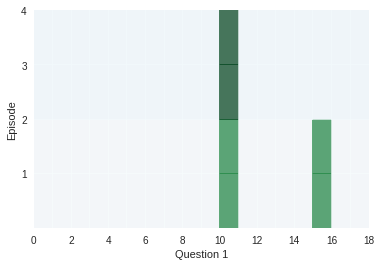

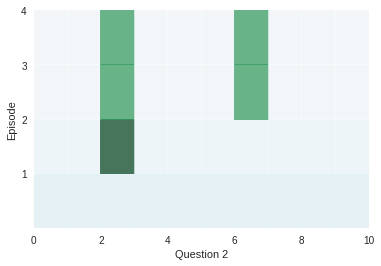

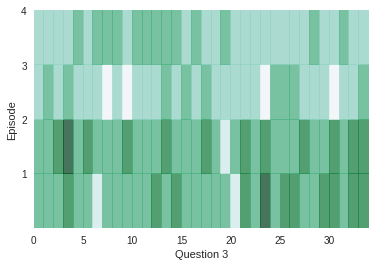

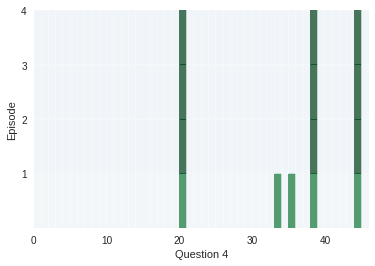

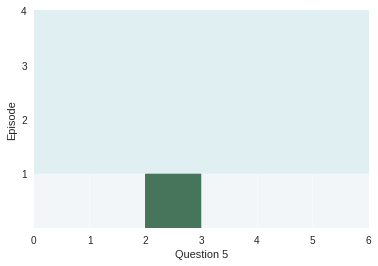

In [23]:
ancr = sess.run([corrbool,locs, total_loss, logits, facts_0s, w_1]+attends+
                [query, cs, question_module_outputs],feed_dict=validation_set)
a = ancr[0]
n = ancr[1]
cr = ancr[2]
attenders = np.array(ancr[6:-3]) 
faq = np.sum(ancr[4], axis=(-1,-2)) # Number of facts in each context

limit = 5
for question in range(min(limit, batch_size)):
    plt.yticks(range(passes,0,-1))
    plt.ylabel("Episode")
    plt.xlabel("Question "+str(question+1))
    pltdata = attenders[:,question,:int(faq[question]),0] 
    # Display only information about facts that actually exist, all others are 0
    pltdata = (pltdata - pltdata.mean()) / ((pltdata.max() - pltdata.min() + 0.001)) * 256
    plt.pcolor(pltdata, cmap=plt.cm.BuGn, alpha=0.7)
    plt.show()

print(list(map((lambda x: x.shape),ancr[3:])), new_ends.shape)

위에 나온 질문에 대해서 답변을 찾기 위해서 우리는 위치로써 문맥 속의 거리 점수에 대한 위치를 활용할 수 있고, 해당 위치에 어떤 단어가 있는지를 확인할 수 있습니다.

In [24]:
# Locations of responses within contexts
indices = np.argmax(n,axis=1)

# Locations of actual answers within contexts 
indicesc = np.argmax(a,axis=1)

for i,e,cw, cqa in list(zip(indices, indicesc, val_context_words, val_cqas))[:limit]:
    ccc = " ".join(cw)
    print("TEXT: ",ccc)
    print ("QUESTION: ", " ".join(cqa[3]))
    print ("RESPONSE: ", cw[i], ["Correct", "Incorrect"][i!=e])
    print("EXPECTED: ", cw[e])
    print()

TEXT:  bill grabbed the football there . bill got the milk there . bill discarded the milk . fred went back to the office . bill took the milk there . bill dropped the milk there . jeff went back to the hallway . jeff went back to the bathroom . mary went to the hallway . bill put down the football . bill journeyed to the bedroom . jeff travelled to the office . mary moved to the garden . mary went back to the kitchen . bill went to the hallway . jeff journeyed to the kitchen . mary got the apple there . mary passed the apple to jeff .
QUESTION:  who received the apple ?
RESPONSE:  jeff Correct
EXPECTED:  jeff

TEXT:  bill went back to the kitchen . bill took the apple there . bill passed the apple to mary . mary handed the apple to fred . fred gave the apple to mary . mary journeyed to the office . mary handed the apple to jeff . mary got the football there . jeff left the apple . mary gave the football to jeff .
QUESTION:  who did mary give the apple to ?
RESPONSE:  fred Incorrect
EX

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  # Remove the CWD from sys.path while we load stuff.


이제 계속 학습시켜봅시다. 좋은 결과를 얻기 위해서 긴 시간동안 학습시켜야 할겁니다. (저의 집에 있는 컴퓨터로는 12시간이 걸렸습니다.) 하지만 결과적으로 매우 높은 정확성을 얻게 될 것입니다(90%가 넘는 값으로 말입니다.)

 

 Jupyter Notebook이 익숙한 사람은 알겠지만 언제든 학습을 중지시킬 수도 있고, 같은 tf.Session을 유지하는 한 만들어진 신경망을 계속 다룰 수 있습니다. 이 방법은 신경망에서 현재 주고 있는 attention과 대답을 시각화하는데 유용한 방법입니다. 

In [25]:
train(training_iterations_count, batch_size)

  0%|          | 1/3125 [00:03<2:47:13,  3.21s/it]

Iter 0.0, Minibatch Loss=  0.6727886 Accuracy=  0.43203124


  3%|▎         | 101/3125 [02:50<1:35:16,  1.89s/it]

Iter 100.0, Minibatch Loss=  0.6727726 Accuracy=  0.5101563


  6%|▋         | 201/3125 [05:40<1:47:48,  2.21s/it]

Iter 200.0, Minibatch Loss=  0.6727657 Accuracy=  0.52265626


 10%|▉         | 301/3125 [08:25<1:30:38,  1.93s/it]

Iter 300.0, Minibatch Loss=  0.6727603 Accuracy=  0.5726563


 13%|█▎        | 401/3125 [11:10<1:38:44,  2.18s/it]

Iter 400.0, Minibatch Loss=  0.6727614 Accuracy=  0.57890624


 16%|█▌        | 501/3125 [13:51<1:33:48,  2.14s/it]

Iter 500.0, Minibatch Loss=  0.6727522 Accuracy=  0.6015625


 19%|█▉        | 601/3125 [16:34<1:29:13,  2.12s/it]

Iter 600.0, Minibatch Loss=  0.67276555 Accuracy=  0.6015625


 22%|██▏       | 701/3125 [19:21<1:24:50,  2.10s/it]

Iter 700.0, Minibatch Loss=  0.6727522 Accuracy=  0.63203126


 26%|██▌       | 801/3125 [22:06<1:29:55,  2.32s/it]

Iter 800.0, Minibatch Loss=  0.67275476 Accuracy=  0.628125


 29%|██▉       | 901/3125 [24:53<1:22:57,  2.24s/it]

Iter 900.0, Minibatch Loss=  0.6727523 Accuracy=  0.625


 32%|███▏      | 1001/3125 [27:39<1:15:36,  2.14s/it]

Iter 1000.0, Minibatch Loss=  0.67274696 Accuracy=  0.63984376


 35%|███▌      | 1101/3125 [30:20<1:07:28,  2.00s/it]

Iter 1100.0, Minibatch Loss=  0.67275417 Accuracy=  0.6507813


 38%|███▊      | 1201/3125 [33:11<1:15:02,  2.34s/it]

Iter 1200.0, Minibatch Loss=  0.67274994 Accuracy=  0.6546875


 42%|████▏     | 1301/3125 [35:58<1:08:31,  2.25s/it]

Iter 1300.0, Minibatch Loss=  0.6727504 Accuracy=  0.6507813


 45%|████▍     | 1401/3125 [38:45<1:02:04,  2.16s/it]

Iter 1400.0, Minibatch Loss=  0.6727599 Accuracy=  0.6304687


 48%|████▊     | 1501/3125 [41:37<55:41,  2.06s/it]

Iter 1500.0, Minibatch Loss=  0.6727494 Accuracy=  0.6640625


 51%|█████     | 1601/3125 [44:27<51:12,  2.02s/it]

Iter 1600.0, Minibatch Loss=  0.67275214 Accuracy=  0.653125


 54%|█████▍    | 1701/3125 [47:16<48:42,  2.05s/it]

Iter 1700.0, Minibatch Loss=  0.6727488 Accuracy=  0.671875


 58%|█████▊    | 1801/3125 [49:56<42:39,  1.93s/it]

Iter 1800.0, Minibatch Loss=  0.6727528 Accuracy=  0.65234375


 61%|██████    | 1901/3125 [52:37<41:52,  2.05s/it]

Iter 1900.0, Minibatch Loss=  0.67276484 Accuracy=  0.6304687


 64%|██████▍   | 2001/3125 [55:26<43:07,  2.30s/it]

Iter 2000.0, Minibatch Loss=  0.6727515 Accuracy=  0.66875


 67%|██████▋   | 2101/3125 [58:04<33:22,  1.96s/it]

Iter 2100.0, Minibatch Loss=  0.672746 Accuracy=  0.675


 70%|███████   | 2201/3125 [1:00:38<29:18,  1.90s/it]

Iter 2200.0, Minibatch Loss=  0.672761 Accuracy=  0.6453125


 74%|███████▎  | 2301/3125 [1:03:21<25:32,  1.86s/it]

Iter 2300.0, Minibatch Loss=  0.67274517 Accuracy=  0.6703125


 77%|███████▋  | 2401/3125 [1:06:01<26:59,  2.24s/it]

Iter 2400.0, Minibatch Loss=  0.67275035 Accuracy=  0.66328126


 80%|████████  | 2501/3125 [1:08:38<21:15,  2.04s/it]

Iter 2500.0, Minibatch Loss=  0.6727542 Accuracy=  0.6640625


 83%|████████▎ | 2601/3125 [1:11:17<17:06,  1.96s/it]

Iter 2600.0, Minibatch Loss=  0.6727489 Accuracy=  0.6703125


 86%|████████▋ | 2701/3125 [1:13:58<14:52,  2.11s/it]

Iter 2700.0, Minibatch Loss=  0.67275184 Accuracy=  0.66015625


 90%|████████▉ | 2801/3125 [1:16:31<09:37,  1.78s/it]

Iter 2800.0, Minibatch Loss=  0.67276883 Accuracy=  0.6351563


 93%|█████████▎| 2901/3125 [1:19:13<07:03,  1.89s/it]

Iter 2900.0, Minibatch Loss=  0.6727612 Accuracy=  0.6421875


 96%|█████████▌| 3001/3125 [1:21:49<04:28,  2.17s/it]

Iter 3000.0, Minibatch Loss=  0.67274827 Accuracy=  0.66875


 99%|█████████▉| 3101/3125 [1:24:21<00:49,  2.05s/it]

Iter 3100.0, Minibatch Loss=  0.67274684 Accuracy=  0.675


100%|██████████| 3125/3125 [1:25:00<00:00,  1.56s/it]


In [26]:
# Final testing accuracy
print(np.mean(sess.run([corrects], feed_dict= prep_batch(final_test_data))[0]))

0.661


우리 모델이 얻은 결과를 다 확인했으면 시스템 자원을 복원하기 위해 session을 닫을 수 있습니다. 

In [0]:
sess.close()

### 여전히 해볼 것과 실험해봐야 할 내용이 많이 있습니다.

 

* bAbI내의 다른 작업들: 우리는 bAbI가 제공하는 많은 작업들을 단순히 샘플링했습니다. 한번 다른 작업에 맞게끔 전처리하는 과정을 바꾸고 우리가 만든 Dynamic Memory Network이 어떻게 동작하는지 확인해봅시다. 물론 새로운 작업을 돌리기 전에 신경망을 재설정하기를 원할 것입니다. 만약 해당 작업이 문맥 속의 답을 보장하지 않는다면 아마 나온 결과를 사전의 단어와 이와 연관된 벡터들 대신에 비교해보고 싶을 겁니다.(이 작업은 6-10 그리고 17-20에 있습니다) 저는 작업 1과 3을 해볼 것을 추천하는데, 이는 test_set_file과 train_set_file의 값을 변경함으로써 해볼 수 있습니다.

* 지도학습: 우리의 attention 메커니즘은 비지도적 학습인데, 이 말은 우리가 어떤 문장이 나와야 되는지에 대해서 정의할 필요가 없는 대신 신경망이 스스로 이를 찾는 방법입니다. 신경망에 손실을 추가해서 attention 메커니즘이 정확한 문장을 찾는지를 확인해보시기 바랍니다.

* Coattention: 입력 문장에 대해서 단순히 넣는 것 대신에, 몇몇 연구자들이 “Dynamic coattention networks”라고 부르는 것에 성공했는데, 이는 행렬을 집어넣을 때 두 문장에 대한 위치를 동시에 나타내주는 방법입니다.
대체 벡터화 scheme과 소스들: 한번 문장과 벡터 사이에 지능화된 매핑 형태를 만들어보시거나 다른 데이터 집합을 사용해보시기 바랍니다. GloVe는 각각 300차원을 가지는 8400억개 독특한 토큰 데이터를 제공합니다. 


<p><em>This post is a collaboration between O'Reilly and </em><a href="https://www.tensorflow.org/"><em>TensorFlow</em></a><em>. </em><a href="http://www.oreilly.com/about/editorial_independence.html"><em>See our statement of editorial independence</em></a><em>.</em></p>